In [0]:

import tensorflow as tf

import csv
import numpy as np
from PIL import Image

from keras import Model

from keras.applications.mobilenet import MobileNet, preprocess_input

#from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback

from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [0]:
## Connect with google drive and read data
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
#import pandas as pd


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Read the Zip file containing Training/Validation images from Google Drive

In [0]:
# Copy the zip file
zip_files_listed = drive.ListFile({'q': "title contains 'zip' and '1Inn16i2eWk5HnyZfLkJNbaGmlL' in parents"}).GetList()
print(len(zip_files_listed))
print(zip_files_listed)

# Print the file names and the identifiers.
#for file in zip_files_listed:
#  print('title {}, id {}'.format(file['title'], file['id']))


# Loop over and create a local copy of all the ZIP files listed 
for filename in zip_files_listed:
  # Initialize GoogleDriveFile instance with file id.
  file = drive.CreateFile({'id': filename['id']})
  file.GetContentFile(filename['title'])      # create a temporary local copy of the file



1
[GoogleDriveFile({'kind': 'drive#file', 'id': '1N2tQ7TI4s6yvyGqPNFrHbe8oMu8iJWkk', 'etag': '"O-ZzQh-gY65a42kIgC9WL9_4IwE/MTU1NjEwNjczOTYxNw"', 'selfLink': 'https://www.googleapis.com/drive/v2/files/1N2tQ7TI4s6yvyGqPNFrHbe8oMu8iJWkk', 'webContentLink': 'https://drive.google.com/uc?id=1N2tQ7TI4s6yvyGqPNFrHbe8oMu8iJWkk&export=download', 'alternateLink': 'https://drive.google.com/file/d/1N2tQ7TI4s6yvyGqPNFrHbe8oMu8iJWkk/view?usp=drivesdk', 'embedLink': 'https://drive.google.com/file/d/1N2tQ7TI4s6yvyGqPNFrHbe8oMu8iJWkk/preview?usp=drivesdk', 'iconLink': 'https://drive-thirdparty.googleusercontent.com/16/type/application/x-zip-compressed', 'title': 'images.zip', 'mimeType': 'application/x-zip-compressed', 'labels': {'starred': False, 'hidden': False, 'trashed': False, 'restricted': False, 'viewed': True}, 'copyRequiresWriterPermission': False, 'createdDate': '2019-04-24T11:52:19.617Z', 'modifiedDate': '2019-04-24T11:52:19.617Z', 'modifiedByMeDate': '2019-04-24T11:52:19.617Z', 'lastViewedBy

### Read the Training and Validation CSV Files

In [0]:
#------------------------------------------------------------------------------------------------------------

train = drive.ListFile({'q': "title contains 'train' and '1Inn16i2eWk5HnyZfLkJNbaGmlL' in parents"}).GetList()

file = drive.CreateFile({'id': train[0]['id']})
file.GetContentFile(train[0]['title'])      # create a temporary local copy of the file


val = drive.ListFile({'q': "title contains 'validation' and '1Inn16i2eWk5HnyZfLkJNbaGmlL' in parents"}).GetList()
file = drive.CreateFile({'id': val[0]['id']})
file.GetContentFile(val[0]['title'])      # create a temporary local copy of the file

print('\n INFO :: train.csv and validation.csv files are successfully copied to the local directory.....')


 INFO :: train.csv and validation.csv files are successfully copied to the local directory.....


## After the Zip file is copied to the local folder, Unzip it

This will create a foldr named images inside the current working directory. All the images will be unzipped as image files inside images folder.

In [0]:
!pwd
!ls
from zipfile import ZipFile
with ZipFile('./images.zip','r') as z:
     z.extractall()
!ls

print('\n Images unzipped successfully.....')

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
/content
adc.json	   images.zip			      train.csv
baggage_claim.jpg  MobileNet_model_Architecture.json  validation.csv
coco.names	   MobileNet_model_Weights.h5	      yolov3.cfg
dining_table.jpg   sample_data			      yolov3.weights
images		   soccer.jpg
adc.json	   images.zip			      train.csv
baggage_claim.jpg  MobileNet_model_Architecture.json  validation.csv
coco.names	   MobileNet_model_Weights.h5	      yolov3.cfg
dining_table.jpg   sample_data			      yolov3.weights
images		   soccer.jpg

 Images unzipped successfully.....


### Setting Parameters

In [0]:
# SETTINGS

# Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). 
# Higher width means more accurate but slower
ALPHA = 1.0 

# MobileNet takes images of size 128*128*3 
IMAGE_SIZE = 128 

# Number of epochs
EPOCHS = 10  

# Depends on your GPU/CPU/RAM
BATCH_SIZE = 32 

DATASET_FOLDER = "./"

TRAIN_CSV = "train.csv"
VALIDATION_CSV = "validation.csv"

images_zip_path = DATASET_FOLDER + "images.zip"



## Building Training Data

In [0]:
import csv

with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords_train = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    
    for col, row in enumerate(reader):
             
        for i, r in enumerate(row[1:7]): # Parse row with seven entities
            row[i+1] = int(r)
            
        #print(row)    
        fname, image_height, image_width, x0, y0, x1, y1, _, _ = row  
        path = "./images/" + fname.split('/')[-1]
        coords_train[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords_train[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords_train[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords_train[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        #print(coords_train)
        paths.append(path)
             

In [0]:
# Locations of the bounding box top-left cordinate (x0,y0) and the width and height
print('\n x0 = {}'.format(coords_train[0,0]))
print('\n y0 = {}'.format(coords_train[0,1]))
print('\n w = {}'.format(coords_train[0,2]))
print('\n h = {}'.format(coords_train[0,3]))



 x0 = 36.906666666666666

 y0 = 23.04

 w = 19.626666666666665

 h = 27.52


### Training Images and the Ground Truths

There are 3005 samples in the training set. The file, ***train.csv*** contains the names of the files as well as the co-ordinates about the ground-truth bounding boxes.


In [0]:
print(coords_train.shape)
print(len(paths))

# Set the ground truths
train_gt=coords_train

(3005, 4)
3005


### Read the actual Training images from the disk

In [0]:

train_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    train_images[i] = preprocess_input(np.array(img, dtype=np.float32))


## Plot the points on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 x0 = 24.6006006006006

 y0 = 16.384

 w = 58.810810810810814

 h = 36.352


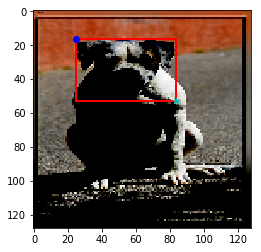

In [0]:
import matplotlib.pyplot as plt

import matplotlib.patches as patches

k=100
img=train_images[k]

x0 = coords_train[k,0]
y0 = coords_train[k,1]
w = coords_train[k,2]
h = coords_train[k,3]


# Locations of the bounding box bottom-left coordinates (x0,y0) and the width and height
print('\n x0 = {}'.format(coords_train[k,0]))
print('\n y0 = {}'.format(coords_train[k,1]))
print('\n w = {}'.format(coords_train[k,2]))
print('\n h = {}'.format(coords_train[k,3]))

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
# x1-x0 is the width of the bounding box
# y1-y0 is the height of the bounding box
rect = patches.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

ax.plot(x0, y0, 'o', color='b')  # top-left corner

ax.plot(x0+w, y0+h, '*', color='c') # bottom-right corner

plt.show()

### Load the Validation Images

In [0]:

with open(VALIDATION_CSV, 'r') as csvfile:
    paths = []
    coords_val = np.zeros((sum(1 for line in csvfile), 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    
    for col, row in enumerate(reader):
                
        for i, r in enumerate(row[1:7]): # Parse row with seven entities
            row[i+1] = int(r)
            
        #print(row)    
        fname, image_height, image_width, x0, y0, x1, y1, _, _ = row  
        path = "./images/" + fname.split('/')[-1]
        coords_val[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box coordinate by image size
        coords_val[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box coordinate by image size
        coords_val[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box width
        coords_val[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height # Normalize bounding box height
        #print(coords_val)
        paths.append(path)

# Set the validation ground truths        
val_gt=coords_val
        
val_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    val_images[i] = preprocess_input(np.array(img, dtype=np.float32))

val_data = (val_images, val_gt) 

## Building the Model - Transfer Learning with MobileNet

In [0]:
# Load pre-trained mobilenet.
# Do not include classification (top) layer

model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) 

# To freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output

# kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Conv2D(4, kernel_size=4, name="coords")(x)

# These are the 4 predicted coordinates of one BBox
x = Reshape((4,))(x) 

model = Model(inputs=model.input, outputs=x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
__________

## Intersection over Union (IoU) Loss Function

In [0]:
def loss(gt, pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0]) # overlapped - width
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1]) # overlapped - height
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

## Training the Model

In [0]:
# Regression loss is MSE
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) 


# Checkpoint best validation model
#checkpoint = ModelCheckpoint("MobileNetmodel-{val_iou:.2f}.h5", verbose=1, save_best_only=True, save_weights_only=True, mode="max", period=1) 
# Stop early, if the validation error deteriorates
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") 
# Reduce learning rate if Validation IOU does not improve
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
#callback=[checkpoint, stop, reduce_lr]
#history = model.fit(x=train_images, y=train_gt, validation_data=val_data, epochs=10, batch_size = 32, verbose=1, callbacks=callback)


history = model.fit(x=train_images, y=train_gt, validation_data=val_data, epochs=10, batch_size = 32, verbose=1)

Train on 3005 samples, validate on 680 samples
Epoch 1/10
3005/3005 [==============================] - 120s 40ms/step - loss: 320.8214 - IoU: 0.4662 - val_loss: 139.1322 - val_IoU: 0.5800
Epoch 2/10
3005/3005 [==============================] - 116s 39ms/step - loss: 105.6107 - IoU: 0.6264 - val_loss: 149.7907 - val_IoU: 0.5991
Epoch 3/10
3005/3005 [==============================] - 117s 39ms/step - loss: 82.9838 - IoU: 0.6567 - val_loss: 113.8832 - val_IoU: 0.6119
Epoch 4/10
3005/3005 [==============================] - 120s 40ms/step - loss: 65.9389 - IoU: 0.6826 - val_loss: 141.5317 - val_IoU: 0.6056
Epoch 5/10
3005/3005 [==============================] - 121s 40ms/step - loss: 55.8375 - IoU: 0.7061 - val_loss: 101.1908 - val_IoU: 0.6204
Epoch 6/10
3005/3005 [==============================] - 118s 39ms/step - loss: 47.8814 - IoU: 0.7245 - val_loss: 109.2850 - val_IoU: 0.6108
Epoch 7/10
3005/3005 [==============================] - 117s 39ms/step - loss: 43.5393 - IoU: 0.7340 - val_loss

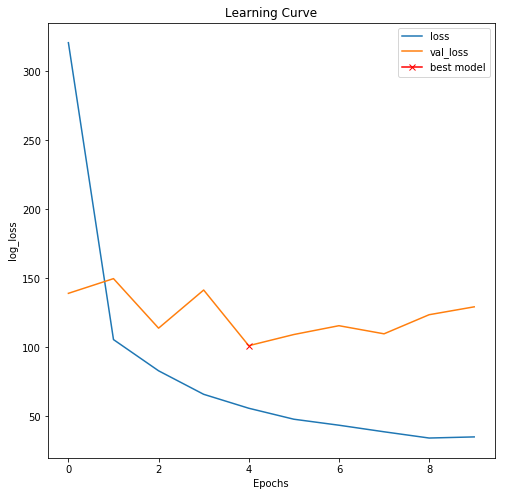

In [0]:
import matplotlib.pyplot as plt
results=history
plt.figure(figsize=(8, 8))
plt.title("Learning Curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# Serialize the Model Architecture and Weights

In [0]:
# Serialize model to JSON
model_json = model.to_json()
with open("MobileNet_model_Architecture.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("MobileNet_model_Weights.h5")

print("Saved model to disk....")

Saved model to disk....




Load the saved model from the disk and make it useful by compiling it.

In [0]:
from keras.models import model_from_json

# load json and create model
json_file = open('MobileNet_model_Architecture.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("MobileNet_model_Weights.h5")
print("\n Loaded model from disk.....")

# Evaluate loaded model on test data
loaded_model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) 

model=loaded_model


 Loaded model from disk.....


## Prediction 

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = './images/shiba_inu_163.jpg'
unscaled = cv2.imread(filename) # Original image for display

In [0]:
image_height, image_width, _ = unscaled.shape

# Rescale image to run the network
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) 

feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

## Pass the image to the model for prediction

The model returns a normalized bounding box.

In [0]:
# Predict the BBox
region = model.predict(x=np.array([feat_scaled]))[0] 

In [0]:
# Locations of the bounding box bottom-left (x0,y0) and the width and height
print('\n x0 = {}'.format(region[0]))
print('\n y0 = {}'.format(region[1]))
print('\n w = {}'.format(region[2]))
print('\n h = {}'.format(region[3]))



 x0 = 32.05209732055664

 y0 = 5.022231578826904

 w = 40.345924377441406

 h = 51.74600601196289


### Scale the bounding box to actual size.

In [0]:
# Scale the BBox
# x0,y0 is the scaled co-ordinates of the top-left corner of the bounding box
x0 = int(region[0] * image_width / IMAGE_SIZE)   
y0 = int(region[1] * image_height / IMAGE_SIZE)

# x1,y1 is the scaled co-ordinates of the bottom-right corner of the bounding box
x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

### Locations of the bounding box coordinates 

** top-left(x0,y0) **

**  botom-right (x1,y1) **

** width of BB (w=x1-x0) **

** height of BB (h=y1-y0)
**

In [0]:
# Locations of the bounding box coordinates top-left(x0,y0), botom-right (x1,y1)
# and the width of BB (w= x1-x0) and height of BB (h=y1-y0)

print('\n x0 = {}'.format(x0))
print('\n y0 = {}'.format(y0))
print('\n x1 = {}'.format(x1))
print('\n y1 = {}'.format(y1))
print('\n w = {}'.format(x1-x0))
print('\n h = {}'.format(y1-y0))




 x0 = 125

 y0 = 14

 x1 = 282

 y1 = 166

 w = 157

 h = 152


## Display Result

Superimpore the predicted bounding box on top of the original image. 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


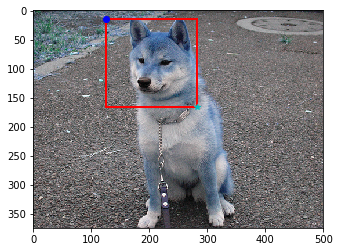

In [0]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
# x1-x0 is the width of the bounding box
# y1-y0 is the height of the bounding box
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

# Image coordinates - top-left of the image is (0,0)

ax.plot(x0, y0, 'o', color='b') # top-left of the bounding box
ax.plot(x1, y1, '*', color='c') # bottom-right of the bounding-box

plt.show()